# Acute Lymphoblastic Leukemia 

Leukemia is a type of cancer that affects the blood and bone marrow. This causes the body to produce too many abnormal white blood cells. These cells cannot fight infections and prevent bone marrow from producing healthy red blood cells and platelets. 

Acute lymphoblastic leukemia is one of the most common type of childhood cancers, totaling up to 25% of pediatric cancers. Identifying leukemic cells from normal cells under the microscope can be challenging becuase of the morphological similarities.


**Task:** Using image classification model, identify normal cells from cancer cells. 

**Data Source:** https://www.kaggle.com/datasets/andrewmvd/leukemia-classification

---

#### ``Objectives``
1. Implement a Convolutional Nural Network (CNN) model to detect leukemic cells from microscopic cell images.
2. Improve generalization performance and reduce overfitting using image transformation and data augmentation techniques.

#### ``Motivation``

Leukemia is a type of cancer that affects the blood and bone marrow, often characterized by abnormal white blood cell production. Early and accurate detection of leukemia through microscopic examination of blood samples is critical for timely treatment and improved patient outcomes. Automating this process with machine learning models can enhance diagnostic efficiency and accessibility, benefiting patients and healthcare systems.

#### ``Data``

The dataset contains microscopic images of blood samples, categorized into two classes:

    - ALL (Cancerous) Cells: Images depicting cells affected by Acute Lymphoblastic Leukemia.
    - Healthy (Non-Cancerous) Cells: Images of normal, healthy blood cells.

The images are organized by training, validation, and test sets, while the training set is divided into three folds (fold_0, fold_1, fold_2). Each fold contains subdirectories that consist of either 'all' (cancerous) cell images or 'hem' (healthy) cell images:

    - Training Set: Contains a total of 10,661 images, with 7,272 images of cancerous cells and 3,389 images of healthy cells.
    - Validation Set: Includes 1,867 images, divided into 1,219 cancerous images and 3,389 healthy images. It also contains a CSV file specifying their labels.
    - Test Set: Contains 2,586 unlabeled images, divided by 1,219 cancerous and 648 healthy images.

Each image is a high-resolution scan of a blood smear that can provide insight into the cellular structures that can be used to identify healthy cells from cancerous ones.

---
### Import Libraries and Load Data

In [ ]:
# Standard Libraries
import pandas as pd
import numpy as np
import random
import os

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras import models, layers

# Sklearn
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Set random seed for reproducibility
random.seed(2)
%matplotlib inline

# Paths
TRAIN_IMAGE_PATH = '/Users/Chris/Desktop/Berkeley MIDS/Fall_2024/DATASCI_207/Final Project/C-NMC_Leukemia/training_data'
VALIDATION_IMAGE_PATH = '/Users/Chris/Desktop/Berkeley MIDS/Fall_2024/DATASCI_207/Final Project/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/'
LABEL_PATH = '/Users/Chris/Desktop/Berkeley MIDS/Fall_2024/DATASCI_207/Final Project/C-NMC_Leukemia/validation_data/'
TEST_IMAGE_PATH = '/Users/Chris/Desktop/Berkeley MIDS/Fall_2024/DATASCI_207/Final Project/C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data/'

# --- Loading Training Data ---
train_images = []
train_labels = []

# Iterate through folds and subfolders in training data
for fold in ['fold_0', 'fold_1', 'fold_2']:
    for category in ['all', 'hem']:
        folder_path = os.path.join(TRAIN_IMAGE_PATH, fold, category)
        label = 1 if category == 'all' else 0  # 1 for cancer (all), 0 for healthy (hem)
        
        # Load images from the folder
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = load_img(img_path, target_size = (224, 224))  # Resize images to 224x224
            train_images.append(img_to_array(img) / 255.0)  # Normalize pixel values
            train_labels.append(label)

# Convert to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)
print(f"Loaded {len(train_images)} training images.")
print(f"Sample training labels: {train_labels[:10]}")  # Print first 10 labels

# --- Loading Validation Data ---
validation_images = []
validation_labels = []

# Load validation labels from CSV
labels = pd.read_csv(LABEL_PATH + 'C-NMC_test_prelim_phase_data_labels.csv')
labels['file_path'] = labels['new_names'].apply(lambda x: os.path.join(VALIDATION_IMAGE_PATH, x))

# Load images and labels
for _, row in labels.iterrows():
    img_path = row['file_path']
    label = row['labels']
    img = load_img(img_path, target_size = (224, 224))  # Resize images
    validation_images.append(img_to_array(img) / 255.0)  # Normalize pixel values
    validation_labels.append(label)

# Convert to numpy arrays
validation_images = np.array(validation_images)
validation_labels = np.array(validation_labels)
print(f"Loaded {len(validation_images)} validation images.")
print(f"Sample validation labels: {validation_labels[:10]}")  # Print first 10 labels

# --- Loading Test Data ---
test_images = []

for idx, img in enumerate(os.listdir(TEST_IMAGE_PATH)):
    img_path = os.path.join(TEST_IMAGE_PATH, img)
    img = load_img(img_path, target_size = (224, 224))  # Resize images
    test_images.append(img_to_array(img) / 255.0)  # Normalize pixel values

test_images = np.array(test_images)
print(f"Loaded {len(test_images)} test images.")
# Note: Test labels may not be available if ground truth is hidden.

# --- Summary of Dataset ---
print(f"Training set: {train_images.shape}, Labels: {train_labels.shape}")
print(f"Validation set: {validation_images.shape}, Labels: {validation_labels.shape}")
print(f"Test set: {test_images.shape}")


Loaded 10661 training images.
Sample training labels: [1 1 1 1 1 1 1 1 1 1]
Loaded 1867 validation images.
Sample validation labels: [1 1 1 0 1 1 0 0 1 1]
Loaded 2586 test images.
Training set: (10661, 224, 224, 3), Labels: (10661,)
Validation set: (1867, 224, 224, 3), Labels: (1867,)
Test set: (2586, 224, 224, 3)


---
### Exploratory Data Analysis (EDA)

#### Histogram Visualizing the Distribution of the Two Classes: 'Healthy (hem)' and 'Cancer (all)'

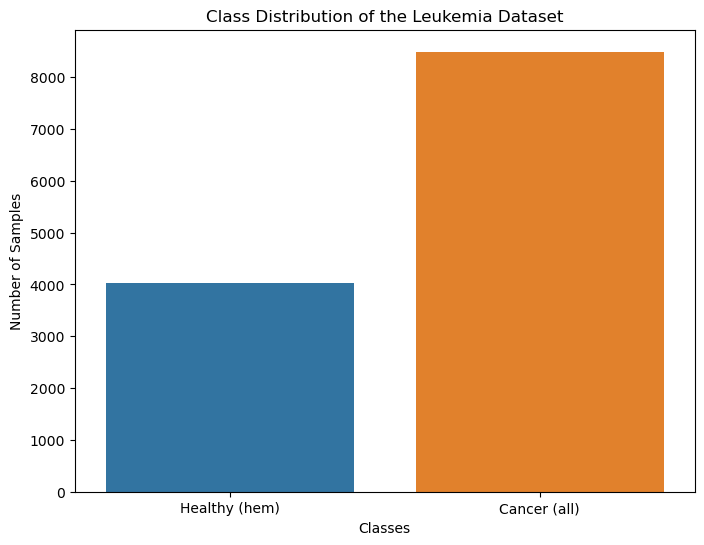

In [ ]:
# Combine labels from all datasets for visualization
combined_labels = np.concatenate([train_labels, validation_labels])

# Count the occurrences of each class
class_counts = np.bincount(combined_labels)
class_names = ['Healthy (hem)', 'Cancer (all)']

# Plot the histogram
plt.figure(figsize = (8, 6))  # Define the figure size only once
sns.barplot(x = class_names, y = class_counts)
plt.title('Class Distribution of the Leukemia Dataset')
plt.ylabel('Number of Samples')
plt.xlabel('Classes')
plt.show()

Class Imbalance Observations:

The classes are not too balanced with roughly 2x more cancer (all) samples compared to healthy (hem). It's not realistic that it would reflect the population as a whole, although could reflect the population sent for testing.

#### 50 Printed Images of the Data: 25 Healthy, 25 Cancerous

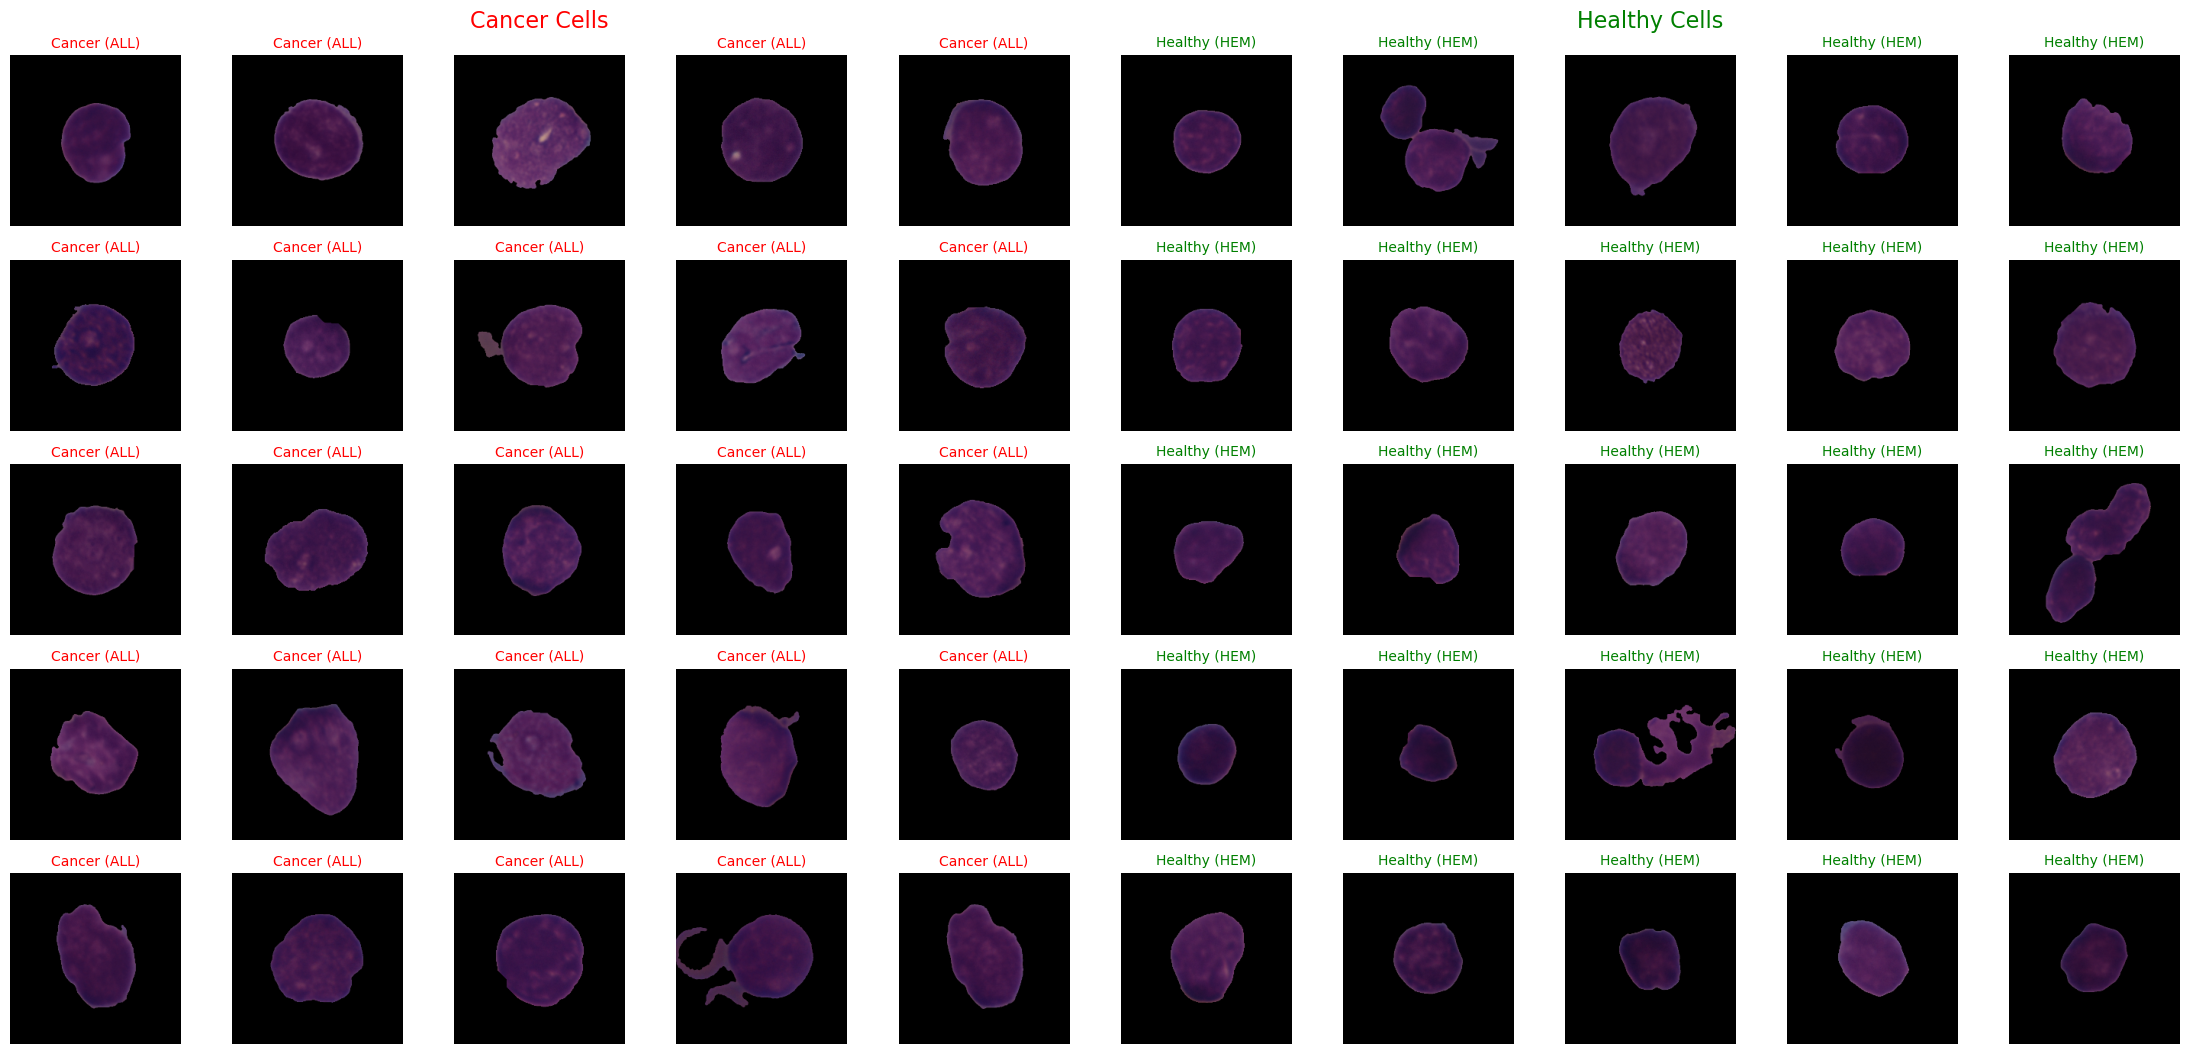

In [ ]:
# Number of images to display for each category
num_cancer_images = 25
num_healthy_images = 25

# Find indices of cancer and healthy images
cancer_indices = np.where(train_labels == 1)[0]
healthy_indices = np.where(train_labels == 0)[0]

# Randomly select 25 cancer and 25 healthy images
selected_cancer_indices = np.random.choice(cancer_indices, num_cancer_images, replace=False)
selected_healthy_indices = np.random.choice(healthy_indices, num_healthy_images, replace=False)

# Create a figure to display the images
fig, axes = plt.subplots(5, 10, figsize=(22, 12))  # 5 rows, 10 columns

# Display Cancer Images (Left 5x5 grid)
for i, idx in enumerate(selected_cancer_indices):
    ax = axes[i // 5, i % 5]  # Position in left 5 columns
    ax.imshow(train_images[idx].astype("float32"))
    ax.axis("off")
    ax.set_title("Cancer (ALL)", fontsize=10, color="red")  # Add label on top of each image
    if i == 2:  # Add title to the top of the left section
        ax.set_title("Cancer Cells", fontsize=16, color="red", pad=20)

# Display Healthy Images (Right 5x5 grid)
for i, idx in enumerate(selected_healthy_indices):
    ax = axes[i // 5, i % 5 + 5]  # Position in right 5 columns
    ax.imshow(train_images[idx].astype("float32"))
    ax.axis("off")
    ax.set_title("Healthy (HEM)", fontsize=10, color="green")  # Add label on top of each image
    if i == 2:  # Add title to the top of the right section
        ax.set_title("Healthy Cells", fontsize=16, color="green", pad=20)

# Add a vertical line to divide the sections
for row in axes:
    for ax in row[4:6]:  # Add a divider between columns 4 and 5
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('black')
        ax.spines['left'].set_linewidth(2)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85, wspace=0.3)  # Add space at the top and between sections
plt.show()

Observations regarding visual appearances of each class:

Size: the images all seem to be the same pixels

Focus: The images have clear cell boundaries and good focus with some boundary abnormalities visible. The orientation is difficult to assess, but the results still may be better with data augmentation to help.

---
### Data Preprocessing

#### Applying Class Weights to Account for Class Imbalance

In [ ]:
# --- Calculate Class Weights ---
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights based on training labels
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)

# Convert class weights to dictionary format
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weight_dict)

# --- Summary of Dataset ---
print(f"Training set: {train_images.shape}, Labels: {train_labels.shape}")
print(f"Validation set: {validation_images.shape}, Labels: {validation_labels.shape}")
print(f"Test set: {test_images.shape}")

Class Weights: {0: 1.5728828562997934, 1: 0.7330170517051705}
Training set: (10661, 224, 224, 3), Labels: (10661,)
Validation set: (1867, 224, 224, 3), Labels: (1867,)
Test set: (2586, 224, 224, 3)


#### Applying Data Augmentation to Improve Generalization

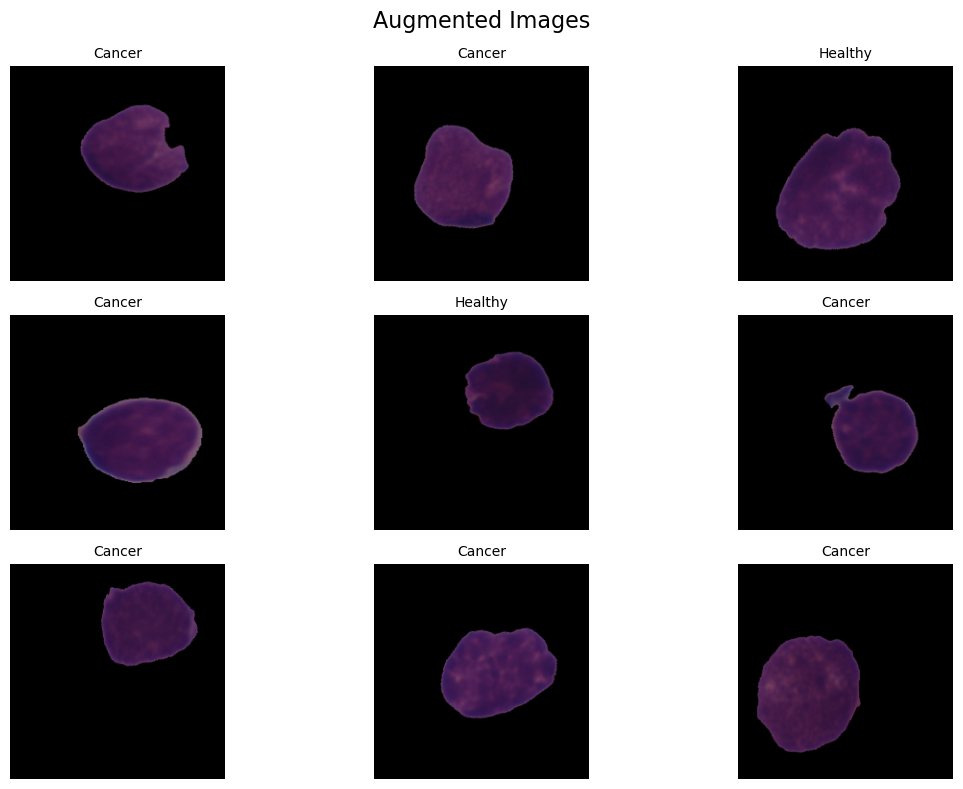

In [32]:
# Data augmentation without altering color
data_augmentation = ImageDataGenerator(
    rotation_range=30,         # Rotate images up to 30 degrees
    width_shift_range=0.2,     # Shift image width up to 20%
    height_shift_range=0.2,    # Shift image height up to 20%
    zoom_range=0.2,            # Random zoom within 20%
    horizontal_flip=True,      # Flip images horizontally
    vertical_flip=False,       # No vertical flip, as it may not make sense for cells
    fill_mode='nearest'        # Fill in any empty pixels with nearest pixel values
)

# Apply augmentations during model training
train_data_gen = data_augmentation.flow(
    train_images, train_labels,
    batch_size=32  # Batch size during training
)

# Generate and visualize augmented images
augmented_images, augmented_labels = next(train_data_gen)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))  # Set figure size
for i in range(9):  # Display 9 augmented images
    plt.subplot(3, 3, i + 1)  # Create a 3x3 grid of images
    plt.imshow(augmented_images[i])  # Display the augmented image
    label = "Cancer" if augmented_labels[i] == 1 else "Healthy"
    plt.title(label, fontsize=10)  # Add label as title
    plt.axis('off')  # Turn off axes for better visualization

plt.suptitle("Augmented Images", fontsize=16)
plt.tight_layout()
plt.show()

#### Data Spltting, Lazy Loading, Batching/Prefetching, and Shuffling of the Data

Data Splitting:

	•	The dataset is shuffled to ensure randomness and then split into training, validation, and test sets using the ratios specified in the splits parameter (default: 60% training, 20% validation, 20% testing).
	•	This is achieved by generating shuffled indices and partitioning the dataset accordingly.

Lazy Loading:

	•	The data is converted into TensorFlow tf.data.Dataset objects, enabling efficient and lazy loading. This approach avoids loading the entire dataset into memory at once, making it suitable for large datasets.

Batching and Prefetching:

	•	The data is batched into chunks of size batch_size (default: 32).
	•	The prefetch method is applied with tf.data.AUTOTUNE, allowing TensorFlow to overlap data preprocessing with model execution, improving pipeline performance and GPU/CPU utilization during training.
	
Shuffling:

	•	Shuffling is applied to the training dataset (shuffle(1000)) to ensure that the training data is presented to the model in a randomized order, preventing the model from learning patterns specific to the sequence of data.

In [33]:
def preprocess_data_with_lazy_loading(images, labels, splits=(0.6, 0.2, 0.2), batch_size=32):
    """Prepares training, validation, and test datasets with lazy loading."""
    
    # Shuffle and split data into train, validation, and test
    data_size = len(images)
    indices = tf.random.shuffle(tf.range(data_size))
    
    train_size = int(splits[0] * data_size)
    val_size = int(splits[1] * data_size)

    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]

    # Create TensorFlow datasets
    X_train, y_train = tf.gather(images, train_indices), tf.gather(labels, train_indices)
    X_val, y_val = tf.gather(images, val_indices), tf.gather(labels, val_indices)
    X_test, y_test = tf.gather(images, test_indices), tf.gather(labels, test_indices)
    
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    
    # Shuffle and batch datasets
    train_dataset = train_dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return train_dataset, val_dataset, test_dataset

# Call the function
split = (0.6, 0.2, 0.2)
batch_size = 32
train_dataset, val_dataset, test_dataset = preprocess_data_with_lazy_loading(
    images=train_images,
    labels=train_labels,
    splits=split,
    batch_size=batch_size
)

# Check the dataset output
for batch_images, batch_labels in train_dataset.take(1):
    print(f"Batch images shape: {batch_images.shape}")
    print(f"Batch labels shape: {batch_labels.shape}")

Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32,)


2024-12-06 00:30:03.172066: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


---
### Modeling

#### Baseline Model

The objective of this code is to build and train a Convolutional Neural Network (CNN) model to classify leukemia cell images into two categories: healthy (hem) and cancerous (all). This binary classification aims to automate the process of distinguishing cancerous cells from healthy ones, thereby supporting early detection and diagnosis of leukemia.

The code implements a CNN classifier as follows:

1.	Implementation:

	•	The model is implemented using TensorFlow’s Keras API.

2.	Input Data:

	•	The model accepts input images of size 224 x 224 x 3 (RGB format, three color channels).

3.	Model Architecture:

	•	The first layer is a convolutional layer with the following specifications:

	•	filters = 12

	•	kernel_size = (4, 4)

	•	strides = (1, 1)

	•	padding = 'same'

	•	data_format = 'channels_last'

	•	activation = 'relu'

	•	name = 'conv_1'

	•	A max-pooling layer with pool size (2, 2) follows the convolutional layer. This reduces the spatial dimensions of the feature maps, thereby decreasing computational complexity while retaining key features.

	•	A dropout layer with a rate of 0.3 is applied after max pooling to reduce the risk of overfitting by randomly deactivating 30% of neurons during training.

	•	A flattening layer transforms the feature maps into a 1D array to prepare the data for the fully connected layer.

	•	A classification layer with a dense unit is added with a sigmoid activation function, which outputs the probability of the image belonging to the cancerous category.

4.	Loss Function:

	•	The model uses binary crossentropy as the loss function, suitable for binary classification problems.


5.	Optimizer:

	•	The model is compiled using the Adam optimizer with a learning rate of 0.01 to balance training speed and stability.

6.	Training:

	•	Class weights are applied during training to address class imbalance, ensuring the model gives more importance to underrepresented classes.

	•	The model is trained for up to 20 epochs using the train_dataset and validated on the val_dataset.

	•	An early stopping mechanism is employed to halt training when the validation loss stops improving for 5 consecutive epochs. This prevents overfitting and reduces unnecessary computation.

7.	Evaluation:

	•	The model’s accuracy and loss are evaluated on both the training and validation datasets, providing insights into its performance.

	•	Performance on a test dataset can also be evaluated to confirm generalization to unseen data.

8.	Visualization:

	•	A plot of training and validation loss over epochs is generated to visualize the learning process and determine convergence trends.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 224, 224, 12)   │           588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 12)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 12)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │       150,529 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,117 (590.30 KB)

 Trainable params: 151,117 (590.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 22s 104ms/step - accuracy: 0.7524 - loss: 0.7374 - val_accuracy: 0.7491 - val_loss: 0.5428
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - accuracy: 0.7965 - loss: 0.4535 - val_accuracy: 0.7528 - val_loss: 0.5445
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - accuracy: 0.8116 - loss: 0.4184 - val_accuracy: 0.7462 - val_loss: 0.5595
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - accuracy: 0.8356 - loss: 0.3696 - val_accuracy: 0.7674 - val_loss: 0.5419
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 103ms/step - accuracy: 0.8500 - loss: 0.3382 - val_accuracy: 0.7795 - val_loss: 0.5516
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 23s 113ms/step - accuracy: 0.8563 - loss: 0.3101 - val_accuracy: 0.7556 - val_loss: 0.6231
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 23s 113ms/step - accuracy: 0.8676 - loss: 0.2932 - val_accuracy: 0.7711 - val_loss: 0.6516
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 23s 115ms/step - accuracy: 0.8754 - loss: 0

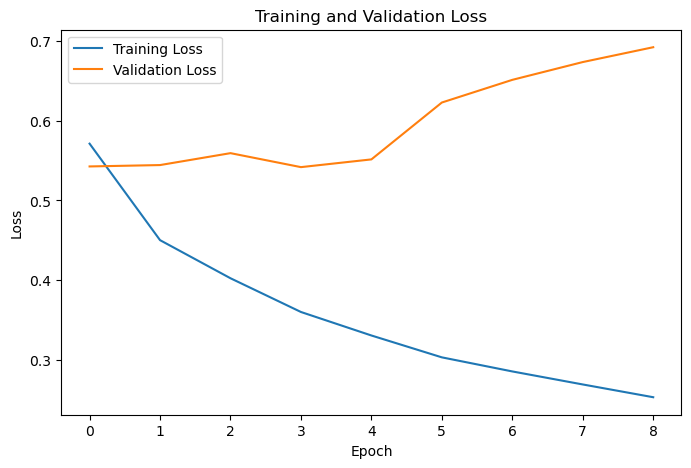

Training Accuracy: 0.8748
Validation Accuracy: 0.7674


In [34]:
# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    verbose=1,
    mode='min', 
    restore_best_weights=True
)

# Set random seeds for reproducibility
tf.random.set_seed(1234)
np.random.seed(1234)

# Initialize the model
model_tf = tf.keras.Sequential()

# Add convolutional layer
model_tf.add(tf.keras.layers.Conv2D(
    filters=12,
    kernel_size=(4, 4),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    activation='relu',
    name='conv_1'
))

# Add max pooling layer
model_tf.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Add dropout layer
model_tf.add(tf.keras.layers.Dropout(rate=0.3))

# Add flattening layer
model_tf.add(tf.keras.layers.Flatten())

# Add classification layer
model_tf.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Build and compile the model
model_tf.build(input_shape=(None, 224, 224, 3))
model_tf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),  # Lower learning rate for stability
                 loss=tf.keras.losses.BinaryCrossentropy(),
                 metrics=['accuracy'])

# Print the model summary
model_tf.summary()

# Assuming class_weight_dict was previously computed using compute_class_weight
# Example:
# class_weight_dict = {0: weight_for_healthy, 1: weight_for_cancer}

# Train the model with class weights
history = model_tf.fit(
    train_dataset,  # Training dataset (from lazy loading pipeline)
    validation_data=val_dataset,  # Validation dataset
    epochs=20,
    callbacks=[early_stopping],
    class_weight=class_weight_dict  # Add class weights here
)

# Plot loss curves
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Evaluate the model on training and validation data
train_loss, train_accuracy = model_tf.evaluate(train_dataset, verbose=0)
val_loss, val_accuracy = model_tf.evaluate(val_dataset, verbose=0)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

Parameters in *model_tf*: 151,117 parameters

Observation of the *model_tf* accuracy on training vs. validation data: 

The training accuracy is 0.8748 verses the validation accuracy of 0.7674. Although the training loss goes down as we run Epochs, we do see the validation go up. This suggests overfitting of the training data.

### Convolutional Neural Network (CNN)

Build and train a Convolutional Neural Network (CNN) to classify leukemia images into two categories: 'Healthy (hem)' and 'Cancer (all)'. This binary classification task aims to identify cancerous samples for further medical evaluation.

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling2D)        │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_2 (MaxPooling2D)        │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_3 (MaxPooling2D)        │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,783,873 (98.36 MB)

 Trainable params: 25,783,873 (98.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 121s 560ms/step - accuracy: 0.7688 - loss: 0.5453 - val_accuracy: 0.7763 - val_loss: 0.5027
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 120s 599ms/step - accuracy: 0.8043 - loss: 0.4959 - val_accuracy: 0.7922 - val_loss: 0.4794
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 123s 617ms/step - accuracy: 0.8092 - loss: 0.4860 - val_accuracy: 0.7946 - val_loss: 0.4793
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 116s 581ms/step - accuracy: 0.8127 - loss: 0.4738 - val_accuracy: 0.7960 - val_loss: 0.4628
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 126s 628ms/step - accuracy: 0.8173 - loss: 0.4654 - val_accuracy: 0.8044 - val_loss: 0.4588
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 129s 643ms/step - accuracy: 0.8223 - loss: 0.4645 - val_accuracy: 0.8030 - val_loss: 0.4959
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 133s 665ms/step - accuracy: 0.8303 - loss: 0.4404 - val_accuracy: 0.7814 - val_loss: 0.5115
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 138s 689ms/step - accuracy: 0.8217 -

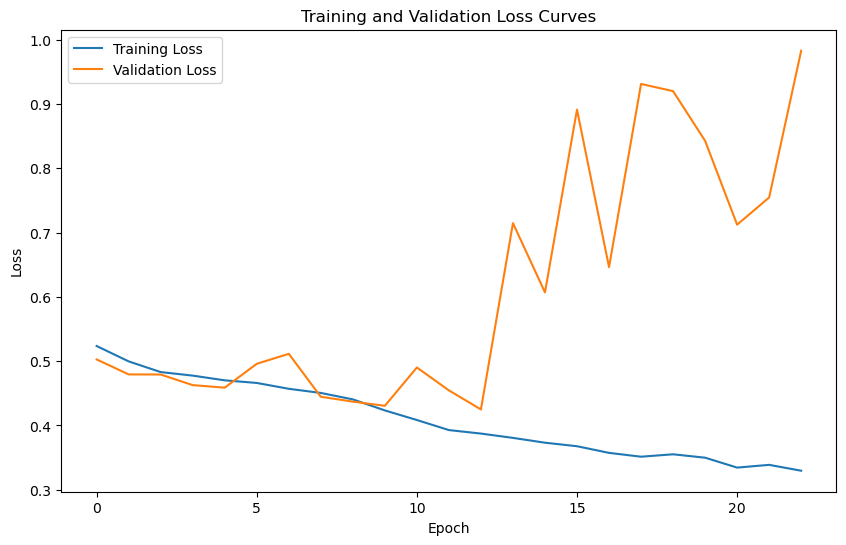

Training Accuracy: 0.8482
Validation Accuracy: 0.8250


In [36]:
# Set random seeds for reproducibility
tf.random.set_seed(1234)
np.random.seed(1234)

# Define class weights to address class imbalance
class_weight_dict = {0: 1.0, 1: 1.2}

# Initialize the fine-tuned CNN model
model_tf = tf.keras.Sequential()

# Add an explicit input layer to handle the input shape
model_tf.add(tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer'))

# Data augmentation layers
model_tf.add(tf.keras.layers.RandomRotation(factor=0.1, name='random_rotation'))
model_tf.add(tf.keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1, name='random_zoom'))
model_tf.add(tf.keras.layers.RandomFlip(mode="horizontal", name='random_flip'))

# First convolutional block
model_tf.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    activation='relu',
    name='conv_1'
))
model_tf.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='maxpool_1'))

# Second convolutional block
model_tf.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    activation='relu',
    name='conv_2'
))
model_tf.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='maxpool_2'))

# Third convolutional block
model_tf.add(tf.keras.layers.Conv2D(
    filters=128,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    activation='relu',
    name='conv_3'
))
model_tf.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='maxpool_3'))

# Dropout layer to prevent overfitting
model_tf.add(tf.keras.layers.Dropout(rate=0.5, name='dropout_1'))

# Flatten layer
model_tf.add(tf.keras.layers.Flatten(name='flatten'))

# Dense hidden layer
model_tf.add(tf.keras.layers.Dense(256, activation='relu', name='dense_1'))
model_tf.add(tf.keras.layers.Dropout(rate=0.4, name='dropout_2'))

# Classification layer
model_tf.add(tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer'))

# Compile the model with an adjusted learning rate
model_tf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                 loss=tf.keras.losses.BinaryCrossentropy(),
                 metrics=['accuracy'])

# Print the model summary
model_tf.summary()

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model with class weights
history = model_tf.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

# Plot loss curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

# Evaluate the model on training and validation datasets
train_loss, train_accuracy = model_tf.evaluate(train_dataset, verbose=0)
val_loss, val_accuracy = model_tf.evaluate(val_dataset, verbose=0)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

How many parameters does your fine-tuned model have? Total parameters: 25,783,873

Observations on the accuracy of the fine-tuned model on training vs. validation performance:

This now fine-tuned model shows a training accuracy of 84.82% vs. validation accuracy of 82.50%. This is an improvement over the non-fine-tuned version, which had a validation accuracy around 76.74%, but improvements can be made.

---
### Step 6: Evaluation

Use test data to evaluate the performance (accuracy) of your fine-tuned model on unseen data. Does your model generalize well?

In [37]:
#using an LLM to assist with coding

# Evaluate the fine-tuned model on the test dataset
test_loss, test_accuracy = model_tf.evaluate(test_dataset, verbose=0)

# Print the test accuracy
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Check if the model generalizes well
if test_accuracy > val_accuracy - 0.05:  # Example: Allow a 5% drop from validation accuracy
    print("The model generalizes well to unseen data.")
else:
    print("The model does not generalize well. Consider further fine-tuning or regularization.")


Test Loss: 0.3791
Test Accuracy: 0.8467
The model generalizes well to unseen data.


Does your model generalize well? 
Yes, the model seems to generalize well with a test accuracy of 84.67%.  It does not seem to be overfitting, which is good.